## Predicting Over/Under 2.5 Goals in the Premier League

This is a **binary classification** problem focused on predicting the target variable `y`, where:

* `y=1` - *Over 2.5* goals,

* `y=0` - *Under 2.5* goals.

Models make theirs predictions based on **historical data**, including crucial **lagged features**, to forecast future match outcomes.

### Dataset
The project contains data from the 2021/22 season to the current one.

Link do Datasets: https://www.football-data.co.uk/englandm.php

Features explanation: https://www.football-data.co.uk/notes.txt


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV

from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score, make_scorer


from google.colab import drive
import warnings

warnings.filterwarnings("ignore")
plt.rcParams['axes.grid'] = True

In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


### Data loading and preparation

In this section, `MatchWeek` and `season` columns were added enable easier filtering and grouping. Additionally, a common set of columns was identified across all datasets to prepare for merging.

In [3]:
path2526="/content/drive/My Drive/PLproject/2526.csv"
path2425="/content/drive/My Drive/PLproject/2425.csv"
path2324="/content/drive/My Drive/PLproject/2324.csv"
path2223="/content/drive/My Drive/PLproject/2223.csv"
path2122="/content/drive/My Drive/PLproject/2122.csv"

In [4]:
data2526 = pd.read_csv(path2526)
data2526['season'] = 2025
data2425 = pd.read_csv(path2425)
data2425['season'] = 2024
data2324 = pd.read_csv(path2324)
data2324['season'] = 2023
data2223 = pd.read_csv(path2223)
data2223['season'] = 2022
data2122 = pd.read_csv(path2122)
data2122['season'] = 2021
datasets = [data2122,
            data2223, data2324, data2425, data2526]

In [5]:
def matchweeks(data:pd.DataFrame):
  matches_in_season = 380
  matches_per_week = 10
  max_matchweek = 38
  data.reset_index(drop=True, inplace=True)
  data['MatchWeek'] = (data.index % matches_in_season) // matches_per_week + 1
  data['MatchWeek'] = data['MatchWeek'].clip(upper=max_matchweek)

  return data

for i in range(len(datasets)):
  datasets[i] = matchweeks(datasets[i])

In [6]:
def cols_per_ses(data:pd.DataFrame):
  cols = list(data.columns)
  return cols
cols_dict = {}
for i in range(len(datasets)):
  cols_dict[f"season{21+i}_cols"] = cols_per_ses(datasets[i])
cols_dict.keys()

dict_keys(['season21_cols', 'season22_cols', 'season23_cols', 'season24_cols', 'season25_cols'])

In [7]:
list21_22 = cols_dict['season21_cols']

list22_23 = cols_dict['season22_cols']
list23_24 = cols_dict['season23_cols']
list24_25 = cols_dict['season24_cols']
list25_26 = cols_dict['season25_cols']

set21_22 = set(list21_22)
set22_23 = set(list22_23)
set23_24 = set(list23_24)
set24_25 = set(list24_25)
set25_26 = set(list25_26)

common_cols = [col for col in list21_22 if col in set22_23 and col in set24_25 and col in set25_26 and col in set23_24]
len(common_cols)

90

In [8]:
data21_22_com_cols = data2122[common_cols]
data22_23_com_cols = data2223[common_cols]
data23_24_com_cols = data2324[common_cols]
data24_25_com_cols = data2425[common_cols]
data25_26_com_cols = data2526[common_cols]
data22_23_com_cols.shape[1]

90

In [9]:
data = pd.concat([data22_23_com_cols, data23_24_com_cols, data24_25_com_cols, data25_26_com_cols], axis=0, ignore_index=True)
data.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,season,MatchWeek
0,E0,05/08/2022,20:00,Crystal Palace,Arsenal,0,2,A,0,1,...,2.09,1.84,2.04,1.88,2.09,1.88,2.03,1.85,2022,1
1,E0,06/08/2022,12:30,Fulham,Liverpool,2,2,D,1,0,...,1.90,2.03,1.91,2.02,2.01,2.06,1.89,1.99,2022,1
2,E0,06/08/2022,15:00,Bournemouth,Aston Villa,2,0,H,1,0,...,1.93,2.00,1.93,2.00,1.94,2.04,1.88,2.00,2022,1
3,E0,06/08/2022,15:00,Leeds,Wolves,2,1,H,1,1,...,2.08,1.85,2.10,1.84,2.14,1.87,2.08,1.81,2022,1
4,E0,06/08/2022,15:00,Newcastle,Nott'm Forest,2,0,H,0,0,...,1.97,1.96,1.99,1.93,2.19,1.97,2.03,1.86,2022,1


In [10]:
data.to_csv('PL_data_21_25.csv', index=False, encoding='utf-8')

### Cleaning the dataset

First, the data was sorted by `date` to ensure correct order, and the target variable `y` was created.

Missing values were handled using a two-step imputation strategy:
* Columns with fewer than 20 NaN values were imputed using their mean.
* For all other columns (with 20 or more missing values), the `IterativeImputer` was applied for a more robust estimation.

In [11]:
def data_rearrange(data:pd.DataFrame):
  data.Date = pd.to_datetime(data.Date, format="mixed")
  data.drop("Div", axis=1, inplace=True)
  data.columns = data.columns.str.lower()
  return data

In [12]:
data = data_rearrange(data)
data.head()

,date,time,hometeam,awayteam,fthg,ftag,ftr,hthg,htag,htr,...,b365cahh,b365caha,pcahh,pcaha,maxcahh,maxcaha,avgcahh,avgcaha,season,matchweek
0,2022-05-08,20:00,Crystal Palace,Arsenal,0,2,A,0,1,A,...,2.09,1.84,2.04,1.88,2.09,1.88,2.03,1.85,2022,1
1,2022-06-08,12:30,Fulham,Liverpool,2,2,D,1,0,H,...,1.90,2.03,1.91,2.02,2.01,2.06,1.89,1.99,2022,1
2,2022-06-08,15:00,Bournemouth,Aston Villa,2,0,H,1,0,H,...,1.93,2.00,1.93,2.00,1.94,2.04,1.88,2.00,2022,1
3,2022-06-08,15:00,Leeds,Wolves,2,1,H,1,1,D,...,2.08,1.85,2.10,1.84,2.14,1.87,2.08,1.81,2022,1
4,2022-06-08,15:00,Newcastle,Nott'm Forest,2,0,H,0,0,D,...,1.97,1.96,1.99,1.93,2.19,1.97,2.03,1.86,2022,1


In [13]:
total_goals = data["fthg"] + data["ftag"]
data["y_over_2"] = np.where(total_goals > 2.5, 1, 0)

In [14]:
data.select_dtypes("object").columns


Index(['time', 'hometeam', 'awayteam', 'ftr', 'htr', 'referee'], dtype='object')

In [15]:
data.time = pd.to_numeric(data.time.astype(str).str.split(":").str[0])

In [16]:
data.loc[:, data.isna().sum()>0].isna().sum()

,0
bwh,143
bwd,143
bwa,143
p>2.5,12
p<2.5,12
bwch,153
bwcd,153
bwca,153
pc>2.5,11
pc<2.5,11


### Columns with NaN value descritpion:

| Columns | Descripiton |
| :--- | :--- |
| * `BWH` | **Bwin** odds for a **Home Win** (1X2 market) |
| * `BWD` | **Bwin** odds for a **Draw** (1X2 market) |
| * `BWA` | **Bwin** odds for an **Away Win** (1X2 market) |
| * `P>2.5` | **Pinnacle** odds for **Over 2.5 Goals** (Goals Total market) |
| * `P<2.5` | **Pinnacle** odds for **Under 2.5 Goals** (Goals Total market) |
| * `BWCH` | **Bwin Closing Odds** for a **Home Win** |
| * `BWCD` | **Bwin Closing Odds** for a **Draw** |
| * `BWCA` | **Bwin Closing Odds** for an **Away Win** |
| * `PC>2.5` | **Pinnacle Closing Odds** for **Over 2.5 Goals** |
| * `PC<2.5` | **Pinnacle Closing Odds** for **Under 2.5 Goals** |
| * `MaxCAHH` | **Maximum Closing Odd** for the **Asian Handicap Home** bet |
| * `MaxCAHA` | **Maximum Closing Odd** for the **Asian Handicap Away** bet |

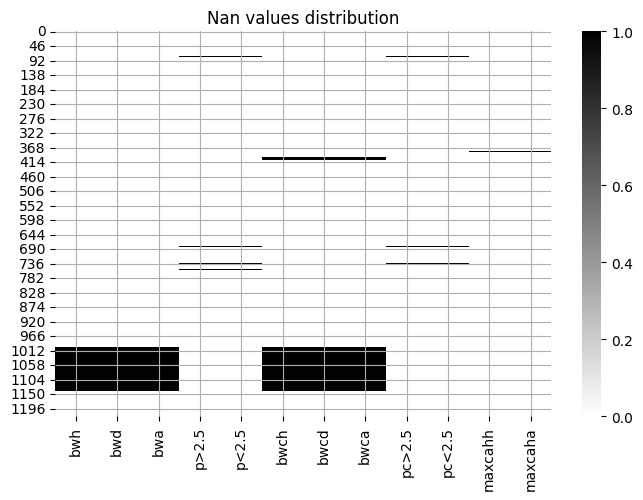

In [17]:
plt.figure(figsize=(8, 5))
sns.heatmap(
    data.loc[:, data.isna().sum()>0].isna(),
    cmap='binary'
)
plt.title("Nan values distribution");

In [18]:
cols_with_less_20_nan = list(data.loc[:, (data.isna().sum()>0) & (data.isna().sum()<20)].isna().columns)
for col in cols_with_less_20_nan:
  data[col].fillna(data[col].mean())


In [19]:
inputer = IterativeImputer(max_iter=10, random_state=77, verbose=1)
inputed_data = inputer.fit_transform(data.drop(['hometeam', 'awayteam', 'ftr', 'htr', 'referee', 'date'], axis=1))


[IterativeImputer] Completing matrix with shape (1220, 84)
[IterativeImputer] Change: 44.378766134126195, scaled tolerance: 2.025 
[IterativeImputer] Change: 5.864590736847029, scaled tolerance: 2.025 
[IterativeImputer] Change: 1.0596178265204985, scaled tolerance: 2.025 
[IterativeImputer] Early stopping criterion reached.


In [20]:
inputed_df = pd.DataFrame(inputed_data, columns=data.drop(['date', 'hometeam', 'awayteam', 'ftr', 'htr', 'referee'], axis=1).columns)
data = data[['date', 'hometeam', 'awayteam', 'ftr', 'htr', 'referee']].join(inputed_df, how="right")

In [21]:
data.isna().sum().sum()

np.int64(0)

In [22]:
data.head()

,date,hometeam,awayteam,ftr,htr,referee,time,fthg,ftag,hthg,...,b365caha,pcahh,pcaha,maxcahh,maxcaha,avgcahh,avgcaha,season,matchweek,y_over_2
0,2022-05-08,Crystal Palace,Arsenal,A,A,A Taylor,20.0,0.0,2.0,0.0,...,1.84,2.04,1.88,2.09,1.88,2.03,1.85,2022.0,1.0,0.0
1,2022-06-08,Fulham,Liverpool,D,H,A Madley,12.0,2.0,2.0,1.0,...,2.03,1.91,2.02,2.01,2.06,1.89,1.99,2022.0,1.0,1.0
2,2022-06-08,Bournemouth,Aston Villa,H,H,P Bankes,15.0,2.0,0.0,1.0,...,2.00,1.93,2.00,1.94,2.04,1.88,2.00,2022.0,1.0,0.0
3,2022-06-08,Leeds,Wolves,H,D,R Jones,15.0,2.0,1.0,1.0,...,1.85,2.10,1.84,2.14,1.87,2.08,1.81,2022.0,1.0,1.0
4,2022-06-08,Newcastle,Nott'm Forest,H,D,S Hooper,15.0,2.0,0.0,0.0,...,1.96,1.99,1.93,2.19,1.97,2.03,1.86,2022.0,1.0,0.0


### Bookmaker columns:

* **`opening_cols`:** The initial odds set by bookmakers, representing their first assessment before late-market information (like lineups or injuries) is available.

* **`closing_cols`:** The final odds available just before kickoff. These are considered the most efficient market price as they reflect all publicly available information.

For further part of the analysis, models use the combined information from **`closing_cols`** and  **`opening_cols`**.



####  Post-Match Statistics (Data Leakage)

* **`leaking_cols`:** Match results known only after the game. These must be removed from the features (`X`) to prevent data leakage.

| Column | Description |
| :--- | :--- |
| * `ftr` | **Full Time Result** (H=Home Win, D=Draw, A=Away Win) |
| * `htr` | **Half Time Result** (H=Home Win, D=Draw, A=Away Win at half-time) |
| * `fthg` | **Full Time Home Goals** (Goals scored by the Home Team) |
| * `ftag` | **Full Time Away Goals** (Goals scored by the Away Team) |
| * `hthg` | **Half Time Home Goals** (Goals scored by the Home Team at half-time) |
| * `htag` | **Half Time Away Goals** (Goals scored by the Away Team at half-time) |
| * `hs` | Home Team **Shots** committed |
| * `as` | Away Team **Shots** committed |
| * `hst` | Home Team **Shots on Target** |
| * `ast` | Away Team **Shots on Target** |
| * `hf` | Home Team **Fouls** committed |
| * `af` | Away Team **Fouls** committed |
| * `hc` | Home Team **Corners** |
| * `ac` | Away Team **Corners** |
| * `hy` | Home Team **Yellow Cards** |
| * `ay` | Away Team **Yellow Cards** |
| * `hr` | Home Team **Red Cards** |
| * `ar` | Away Team **Red Cards** |

In [23]:
leaking_cols = [
    'ftr', 'htr', 'fthg', 'ftag', 'hthg', 'htag',
    'hs', 'as', 'hst', 'ast', 'hf', 'af', 'hc', 'ac',
    'hy', 'ay', 'hr', 'ar'
]


opening_cols = [
    'b365h', 'b365d', 'b365a', 'bwh', 'bwd', 'bwa',
    'psh', 'psd', 'psa', 'maxh', 'maxd', 'maxa',
    'avgh', 'avgd', 'avga', 'b365>2.5', 'b365<2.5',
    'p>2.5', 'p<2.5', 'max>2.5', 'max<2.5', 'avg>2.5',
    'avg<2.5', 'ahh', 'b365ahh', 'b365aha', 'pahh',
    'paha', 'maxahh', 'maxaha', 'avgahh', 'avgaha'
]


closing_cols = [
    'b365ch', 'b365cd', 'b365ca','bwch', 'bwcd', 'bwca',
    'psch', 'pscd', 'psca','maxch', 'maxcd', 'maxca',
    'avgch', 'avgcd', 'avgca','b365c>2.5', 'b365c<2.5',
    'pc>2.5', 'pc<2.5','maxc>2.5', 'maxc<2.5','avgc>2.5', 'avgc<2.5',
    'b365cahh', 'b365caha','pcahh', 'pcaha','maxcahh', 'maxcaha','avgcahh', 'avgcaha'
]

### Categorical Columns Transformation:
In this step, categorical columns such as team names and match results are transformed using `LabelEncoder`.  
The data type of these columns changes from `object` to `int`, allowing the model to process them numerically.


In [24]:
teams_names = list(data.hometeam.unique())

In [25]:
teams_endocer = LabelEncoder()
teams_endocer.fit(teams_names)
data["hometeam_labeled"] = teams_endocer.transform(data.hometeam)
data["awayteam_labeled"] = teams_endocer.transform(data.awayteam)

In [26]:
match_results = list(data.ftr.unique())
match_results

['A', 'D', 'H']

In [27]:
result_endocer = LabelEncoder()
result_endocer.fit(match_results)
data["ftr_labeled"] = result_endocer.transform(data.ftr)
data["htr_labeled"] = result_endocer.transform(data.htr)

In [28]:
ftr = {"A" : 0,
       "D" : 1,
       "H" : 3}

In [29]:
df = data.copy()

In [30]:
df.shape

(1220, 94)

In [31]:
stats_map = {
    'shots_on_target': ('hst', 'ast'),
    'shots': ('hs', 'as'),
    'corners': ('hc', 'ac'),

    'fouls': ('hf', 'af'),
    'yellow_cards': ('hy', 'ay'),
    'red_cards': ('hr', 'ar'),

    'goals_scored': ('fthg', 'ftag'),
    'goals_conceded': ('ftag', 'fthg')
}


In [32]:
df_home = df.copy()
df_away = df.copy()

df_home["team"] = df_home["hometeam"]
df_home["location"] = "home"
df_away["team"] = df_away["awayteam"]
df_away["location"] = "away"

In [33]:
for stat_name, (home_col, away_col) in stats_map.items():
    df_home[stat_name] = df_home[home_col]
    df_away[stat_name] = df_away[away_col]

In [34]:
df_stats = pd.concat([df_home, df_away])

In [35]:
df_stats = df_stats.sort_values(by=['team', 'date'])
df_stats.tail()

,date,hometeam,awayteam,ftr,htr,referee,time,fthg,ftag,hthg,...,team,location,shots_on_target,shots,corners,fouls,yellow_cards,red_cards,goals_scored,goals_conceded
1175,2025-09-13,Newcastle,Wolves,H,H,C Kavanagh,15.0,1.0,0.0,1.0,...,Wolves,away,3.0,8.0,4.0,17.0,4.0,0.0,0.0,1.0
1184,2025-09-20,Wolves,Leeds,A,A,A Taylor,15.0,1.0,3.0,1.0,...,Wolves,home,6.0,16.0,4.0,11.0,1.0,0.0,1.0,3.0
1196,2025-09-27,Tottenham,Wolves,D,D,M Salisbury,20.0,1.0,1.0,0.0,...,Wolves,away,3.0,9.0,9.0,11.0,2.0,0.0,1.0,1.0
1113,2025-10-05,Wolves,Brighton,A,A,M Oliver,15.0,0.0,2.0,0.0,...,Wolves,home,3.0,10.0,7.0,8.0,1.0,0.0,0.0,2.0
1215,2025-10-18,Sunderland,Wolves,H,H,R Jones,15.0,2.0,0.0,1.0,...,Wolves,away,3.0,16.0,2.0,12.0,0.0,0.0,0.0,2.0


In [36]:
df.date.tail()

,date
1215,2025-10-18
1216,2025-10-18
1217,2025-10-19
1218,2025-10-19
1219,2025-10-20


### Rolling averages
The `rolling_averages` function uses match statistics (`leaking_cols`) to generate features that capture a team's recent form, thus improving historical learning.

Crucially, the `closed="left"` parameter is used to explicitly prevent data leakage, ensuring the averages are calculated solely from past match data and exclude any information from the current match being predicted.


Beyond the basic rolling averages, three highly informative **derived features** were created to model team efficiency and performance differential:

1.  **`shots_accuracy`:**  This metric measures the **historical accuracy of shooting**, providing insight into how frequently a team manages to hit the target when attempting a shot.
2.  **`goals_dff`:** This feature represents the team's net goal performance over the last five matches
3.  **`shots_per_goal`:** This is a measure of historical offensive efficiency, showing how many shots on target, on average, are needed to score a goal. A lower value indicates higher finishing accuracy.


In [37]:
def rolling_averages(group, cols, new_cols):
  group.sort_values(by="date")
  rolling_stats = group[cols].rolling(window=5, closed="left").mean()
  group[new_cols]=rolling_stats
  group.dropna(subset=new_cols, inplace=True)
  return group


In [38]:
cols = list(stats_map.keys())
new_cols = [f"{c}_rolling" for c in cols]


In [39]:
df_rolling = df_stats.groupby(["team", "location"]).apply(rolling_averages, cols, new_cols)
df_rolling.reset_index(drop=True, inplace=True)
df_rolling.head()

,date,hometeam,awayteam,ftr,htr,referee,time,fthg,ftag,hthg,...,goals_scored,goals_conceded,shots_on_target_rolling,shots_rolling,corners_rolling,fouls_rolling,yellow_cards_rolling,red_cards_rolling,goals_scored_rolling,goals_conceded_rolling
0,2022-10-16,Leeds,Arsenal,A,A,C Kavanagh,14.0,0.0,1.0,0.0,...,1.0,0.0,4.0,13.4,4.6,10.6,2.0,0.0,2.0,0.6
1,2022-10-23,Southampton,Arsenal,D,A,R Jones,14.0,1.0,1.0,0.0,...,1.0,1.0,4.2,12.0,4.2,11.0,1.8,0.0,2.0,0.0
2,2022-12-11,Wolves,Arsenal,A,D,S Attwell,19.0,0.0,2.0,0.0,...,2.0,0.0,4.4,12.4,4.0,10.4,1.6,0.0,1.8,0.2
3,2022-12-31,Brighton,Arsenal,A,A,A Taylor,17.0,2.0,4.0,0.0,...,4.0,2.0,4.8,12.4,3.6,9.0,1.6,0.0,2.0,0.2
4,2023-01-15,Tottenham,Arsenal,A,A,C Pawson,16.0,0.0,2.0,0.0,...,2.0,0.0,5.0,12.4,3.6,9.2,2.0,0.0,2.2,0.6


In [40]:
df_rolling["shots_accuracy"] = df_rolling.shots_on_target_rolling / df_rolling.shots_rolling
df_rolling["goals_dff"] = df_rolling.goals_scored_rolling - df_rolling.goals_conceded_rolling
df_rolling["shots_per_goal"] = df_rolling.goals_scored_rolling / df_rolling.shots_on_target_rolling

In [41]:
cols_to_remove = [
    'hometeam', 'awayteam', 'fthg', 'ftag', 'hthg', 'htag', 'htr',
    'hs', 'as', 'hst', 'ast', 'hf', 'af', 'hc', 'ac', 'hy', 'ay', 'hr', 'ar',
    'hometeam_labeled', 'awayteam_labeled', 'htr_labeled'
]
df_rolling.drop(columns=[ "referee"]+cols_to_remove, axis=1, inplace=True)

In [42]:
df_rolling.select_dtypes("object")


,ftr,team,location
0,A,Arsenal,away
1,D,Arsenal,away
2,A,Arsenal,away
3,A,Arsenal,away
4,A,Arsenal,away
...,...,...,...
2187,D,Wolves,home
2188,A,Wolves,home
2189,A,Wolves,home
2190,A,Wolves,home


In [43]:
teams_endocer = LabelEncoder()
teams_endocer.fit(teams_names)
df_rolling["team_labeled"] = teams_endocer.transform(df_rolling.team)
#df_rolling.drop(columns="team", inplace=True)
teams_labels = {}
for i in range(len(list(teams_endocer.classes_))):
  teams_labels[list(teams_endocer.classes_)[i]] = i
pd.Series(teams_labels.keys(), index=teams_labels.values())

,0
0,Arsenal
1,Aston Villa
2,Bournemouth
3,Brentford
4,Brighton
5,Burnley
6,Chelsea
7,Crystal Palace
8,Everton
9,Fulham


In [44]:
location_endocer = LabelEncoder()
location_endocer.fit(list(df_rolling.location.unique()))
df_rolling["location_labeled"] = location_endocer.transform(df_rolling.location)
#df_rolling.drop(columns="location", inplace=True)

In [45]:
df_rolling.insert(0, "team", df_rolling.pop("team"))

### Season 2024/25 Visualizations
2024-08-16 to 2025-05-25.

The following visualizations compare the top 3 teams of the 2024/25 season — *Liverpool, Arsenal, and Manchester City* — with **Southampton**, which finished in the last place of the table.  
Additional charts also highlight a direct comparison between the league leader (Liverpool) and the runner-up (Arsenal).  

We analyze and visualize performance metrics such as the trend of goals scored, goals conceded, and shots on target throughout the season. These comparisons allow us to observe how consistency and efficiency in attack and defense differed between the top teams and Southampton.


In [46]:
top_3_2425_with_southampton = ["Liverpool", "Arsenal", "Man City", "Southampton"]
df_2425 = df_rolling[(df_rolling["season"] == 2024)]
teams_colors = {
    "Liverpool" : "#C8102E",
    "Arsenal" : "goldenrod",
    "Man City" : "lightblue",
    "Southampton" : "black"
}

Text(0.5, 0, 'Date')

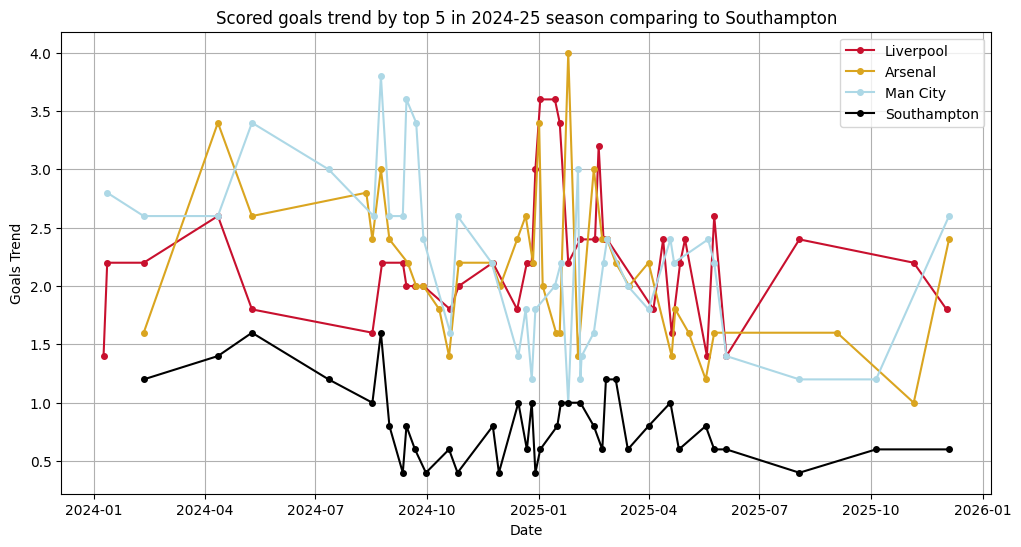

In [47]:
fig, ax = plt.subplots(figsize=(12, 6))

for team in top_3_2425_with_southampton:

  top5 = df_2425[df_2425['team'] == team].sort_values('date')
  ax.plot(top5['date'], top5['goals_scored_rolling'], label=team, marker='o', ms=4, color=teams_colors[team])

ax.legend()
ax.set_title("Scored goals trend by top 5 in 2024-25 season comparing to Southampton")
ax.set_ylabel("Goals Trend")
ax.set_xlabel("Date")

Text(0.5, 0, 'Team')

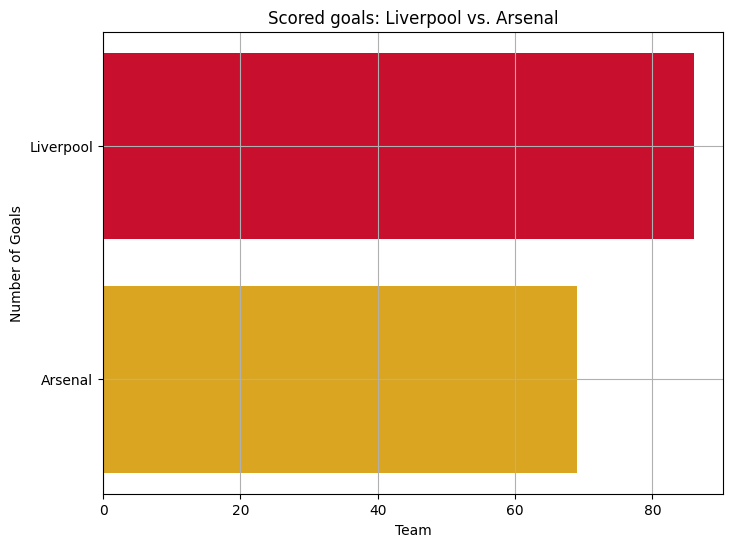

In [48]:
liders = ["Arsenal", "Liverpool"]
fig, ax = plt.subplots(figsize=(8, 6))

for team in liders:
  top5 = df_2425[df_2425['team'] == team].sort_values('date')
  ax.barh(top5['team'], top5['goals_scored'].sum(), label=team, color=teams_colors[team])

ax.set_title("Scored goals: Liverpool vs. Arsenal")
ax.set_ylabel("Number of Goals")
ax.set_xlabel("Team")

Text(0.5, 0, 'Date')

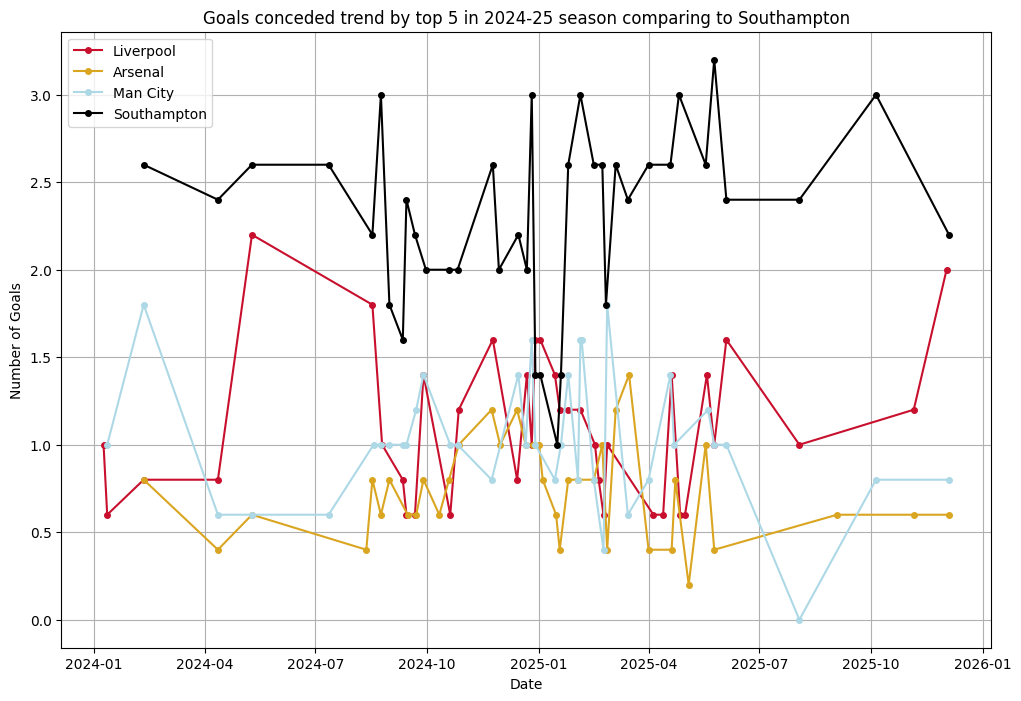

In [49]:
fig, ax = plt.subplots(figsize=(12, 8))

for team in top_3_2425_with_southampton:
    top5 = df_2425[df_2425['team'] == team].sort_values('date')
    ax.plot(top5['date'], top5['goals_conceded_rolling'], label=team, marker='o', ms=4, color=teams_colors[team])

ax.legend()
ax.set_title("Goals conceded trend by top 5 in 2024-25 season comparing to Southampton")
ax.set_ylabel("Number of Goals")
ax.set_xlabel("Date")

Text(0.5, 0, 'Date')

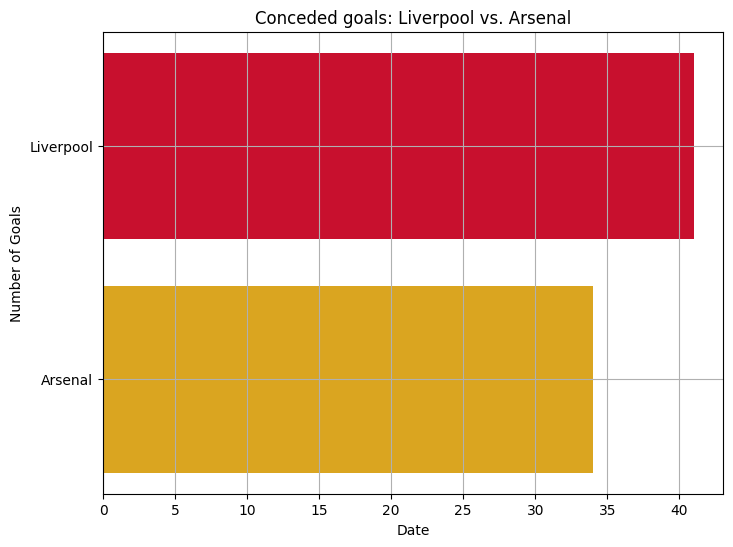

In [50]:
fig, ax = plt.subplots(figsize=(8, 6))

for team in liders:
  top5 = df_2425[df_2425['team'] == team].sort_values('date')
  ax.barh(top5['team'], top5['goals_conceded'].sum(), label=team, color=teams_colors[team])

ax.set_title("Conceded goals: Liverpool vs. Arsenal")
ax.set_ylabel("Number of Goals")
ax.set_xlabel("Date")

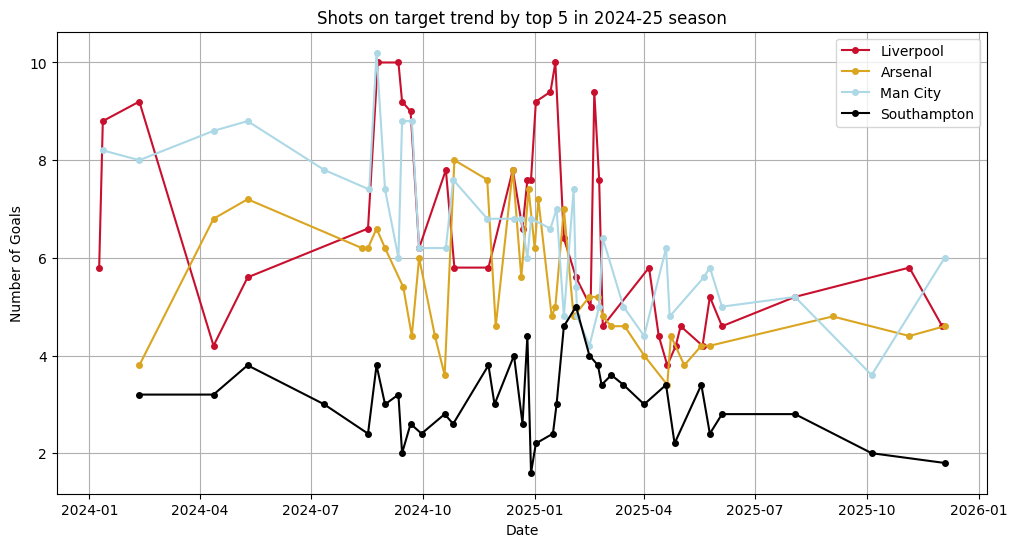

In [51]:
fig, ax = plt.subplots(figsize=(12, 6))

for team in top_3_2425_with_southampton:
    top5 = df_2425[df_2425['team'] == team].sort_values('date')
    ax.plot(top5['date'], top5['shots_on_target_rolling'], label=team, marker='o', ms=4, color=teams_colors[team])

ax.legend()
ax.set_title("Shots on target trend by top 5 in 2024-25 season")
ax.set_ylabel("Number of Goals")
ax.set_xlabel("Date");

Text(0.5, 0, 'Date')

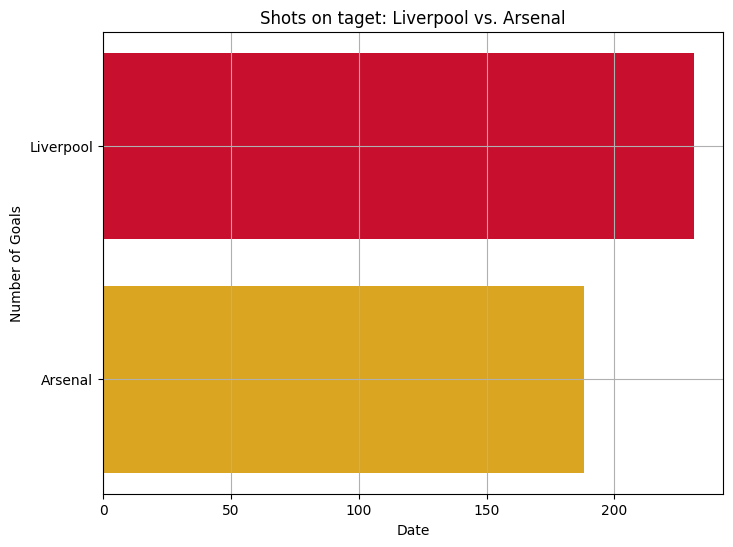

In [52]:
fig, ax = plt.subplots(figsize=(8, 6))

for team in liders:
  top5 = df_2425[df_2425['team'] == team].sort_values('date')
  ax.barh(top5['team'], top5['shots_on_target'].sum(), label=team, color=teams_colors[team])

ax.set_title("Shots on taget: Liverpool vs. Arsenal")
ax.set_ylabel("Number of Goals")
ax.set_xlabel("Date")

In [53]:
goals_concede_by_every_team = {}
goals_scored_by_every_team = {}
for team in df_2425.team.unique():
  goals_scored_by_every_team[team] = df_2425.groupby("team").get_group(team).goals_scored.sum()
  goals_concede_by_every_team[team] = df_2425.groupby("team").get_group(team).goals_conceded.sum()

goals_concede_by_every_team = pd.Series(goals_concede_by_every_team).sort_values(ascending=False)
goals_scored_by_every_team = pd.Series(goals_scored_by_every_team).sort_values(ascending=False)

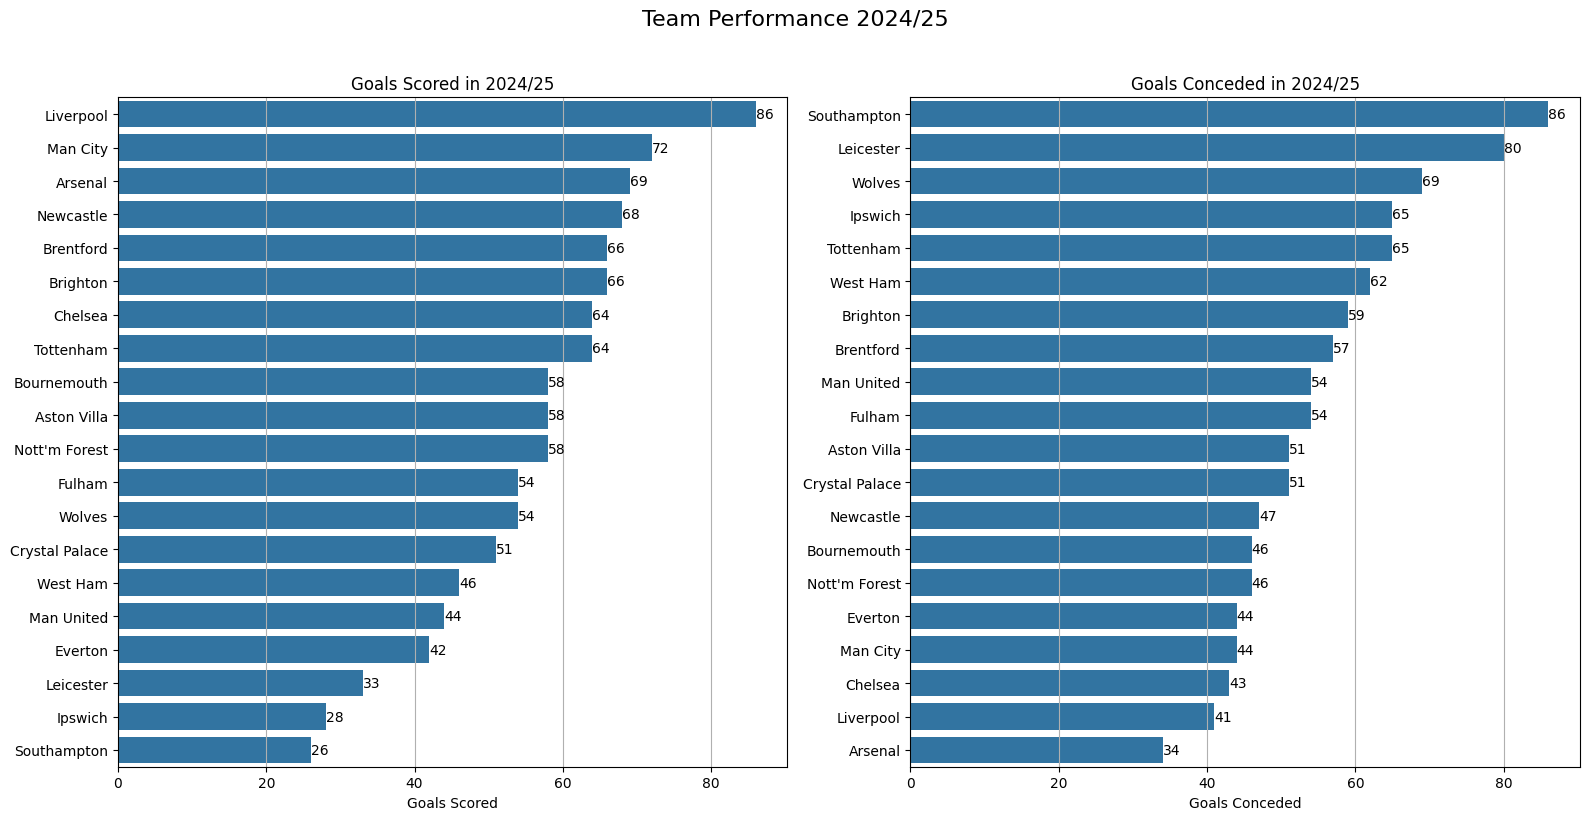

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

sns.barplot(
    x=goals_scored_by_every_team.values,
    y=goals_scored_by_every_team.index,
    ax=axes[0]
)
axes[0].bar_label(axes[0].containers[0], fontsize=10)
axes[0].set_title("Goals Scored in 2024/25")
axes[0].set_xlabel("Goals Scored")
axes[0].set_ylabel("")


sns.barplot(
    x=goals_concede_by_every_team.values,
    y=goals_concede_by_every_team.index,
    ax=axes[1]
)
axes[1].bar_label(axes[1].containers[0], fontsize=10)
axes[1].set_title("Goals Conceded in 2024/25")
axes[1].set_xlabel("Goals Conceded")
axes[1].set_ylabel("")



plt.suptitle("Team Performance 2024/25", fontsize=16, y=1.02)
plt.tight_layout()


### Betting Odds Transformation

This section focuses on transforming raw betting odds into normalized, interpretable probabilistic features for better model performance.

The key transformation steps are:
1.  Removing Margin (Vig/Overround): Raw odds are adjusted to eliminate the bookmaker's margin, yielding true implied probabilities.
2. Market Efficiency Features: New metrics are derived to capture market dynamics, including the market margin (`market_vig_o2.5`), market disagreement (`market_disagree_over_2.5`), and odds movement (`prob_steam_over_2.5`).

This process converts noisy odds data into clean, comparable features that integrate market expectations directly into the predictive model.

In [55]:
features_cols = ['team_labeled',
    'location_labeled',
    #'season',
    "time",
    'matchweek',
    'shots_on_target_rolling',
    'shots_rolling',
    "shots_accuracy",
    'corners_rolling',
    'fouls_rolling',
    'yellow_cards_rolling',
    'red_cards_rolling',
    'goals_scored_rolling',
    'goals_conceded_rolling',
    "goals_dff",
    "shots_per_goal",

      "y_over_2"]

In [56]:
overround_ou_close = (1 / df_rolling['avgc>2.5']) + (1 / df_rolling['avgc<2.5'])
df_rolling['prob_over_2.5'] = (1 / df_rolling['avgc>2.5']) / overround_ou_close
df_rolling["market_dasagree_over_2.5"] = df_rolling["max>2.5"] - df_rolling["avg>2.5"]

df_rolling['market_vig_o2.5'] = (1 / df_rolling['avgc>2.5']) + (1 / df_rolling['avgc<2.5']) - 1

df_rolling['market_vig_1x2'] = (1 / df_rolling['avgch']) + (1 / df_rolling['avgcd']) + (1 / df_rolling['avgca']) - 1

df_rolling['prob_steam_over_2.5'] = df_rolling['prob_over_2.5'] - ((1 / df_rolling['avg>2.5']) / ((1 / df_rolling['avg>2.5']) + (1 / df_rolling['avg<2.5'])))

concs_from_bets = ['prob_steam_over_2.5', "prob_over_2.5", "market_dasagree_over_2.5", "market_vig_o2.5", "market_vig_1x2"]

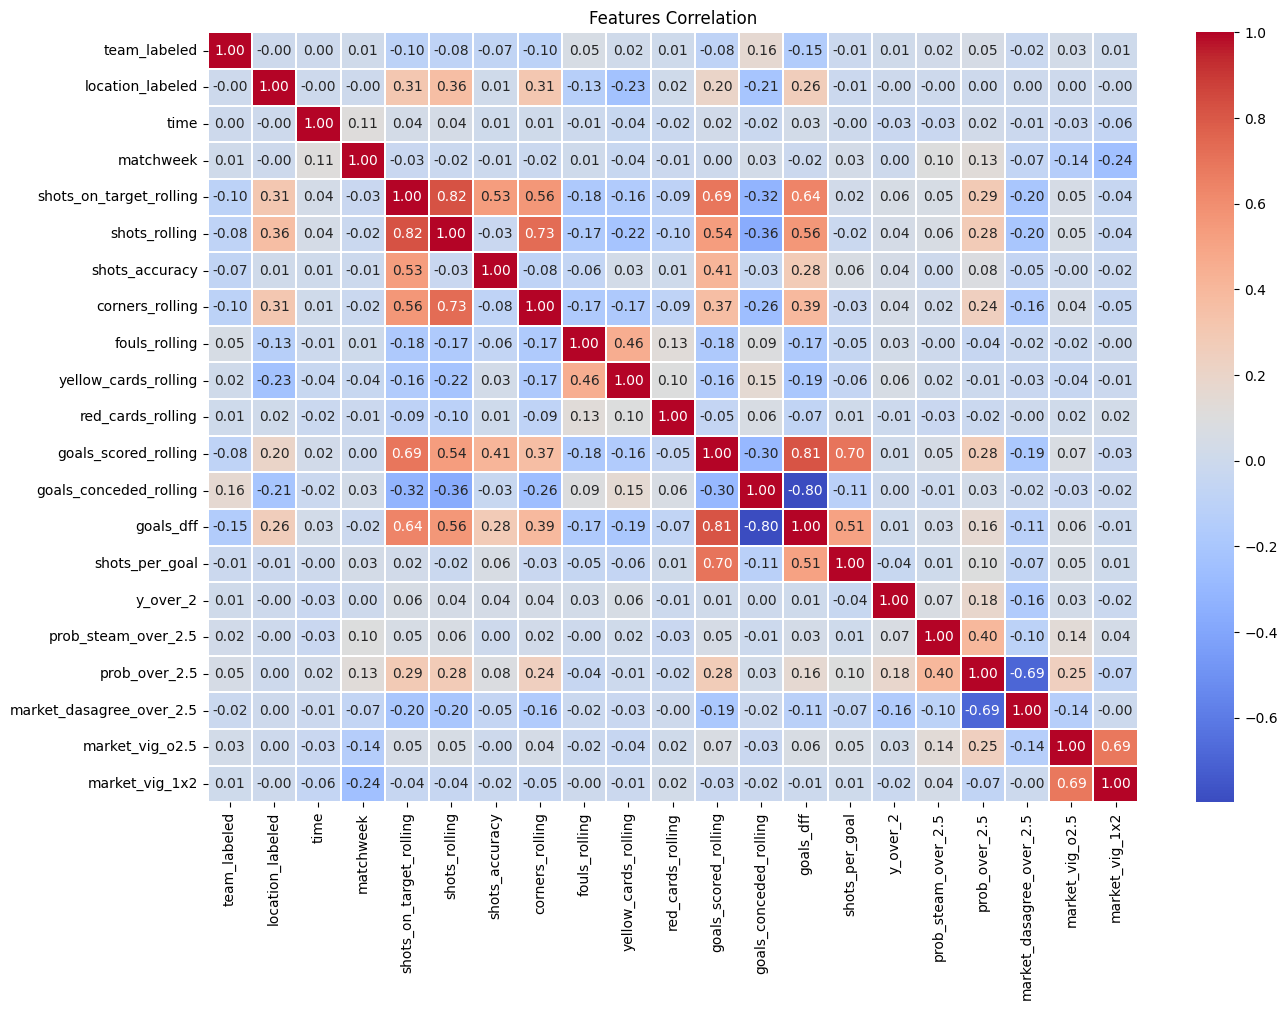

In [57]:
plt.figure(figsize=(15, 10))
ax=sns.heatmap(
    data=df_rolling[features_cols+concs_from_bets].corr(),
    cmap="coolwarm",
    annot=True,
    linewidths=0.2,
    fmt=".2f")
ax.grid(False)
plt.title("Features Correlation");

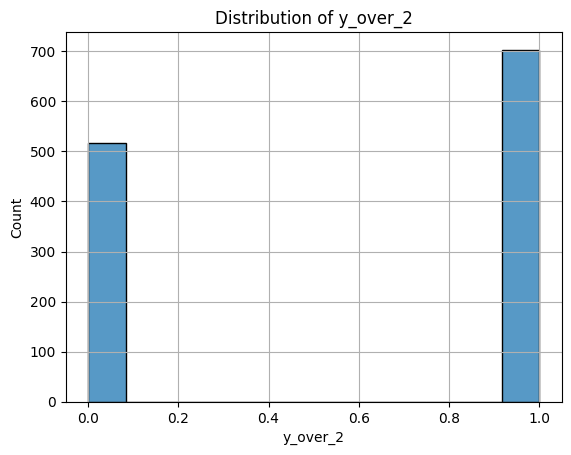

In [58]:
ax = sns.histplot(data= df.y_over_2)
ax.set_title("Distribution of y_over_2");

In [59]:
df_rolling[features_cols+concs_from_bets].shape

(2192, 21)

### Model Training: Random Forest Classifier

#### Hyperparameter Tuning with TimeSeriesSplit
- The model is optimized by searching for the best combination of tree parameters, ensuring it captures complex patterns without overfitting.  
- Time-series cross-validation is used to train on past matches and test on future matches, preventing leaking.  
- Precision is used as the evaluation metric to focus on the accuracy of predicted over 2.5 goal matches.

#### Feature Importance
- After training, feature importance is analyzed to identify which variables contribute most to predictions.  
- This validates the feature engineering process and highlights key predictive factors such as rolling averages and transformed betting odds.

In [60]:
rand_forest_results = {
     "acc": [],
     "prec": [],
     "recall": [],
     "f1": []
     }

log_reg_results = {
     "acc": [],
     "prec": [],
     "recall": [],
     "f1" : []}
svc_results = {
     "acc": [],
     "prec": [],
     "recall": [],
     "f1" : []}


In [61]:
X_train, X_test, y_train, y_test = train_test_split(df_rolling[features_cols+concs_from_bets].drop("y_over_2", axis=1), df_rolling[features_cols+concs_from_bets].y_over_2, test_size=0.2, random_state=77)


In [62]:
rf = RandomForestClassifier(random_state=77,
                            class_weight="balanced")

In [63]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

In [64]:
tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(rf, param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=1, scoring="precision")
grid.fit(X_train, y_train);

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [65]:
grid.best_params_

{'max_depth': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 200}

In [66]:
rf_best = grid.best_estimator_
best_features = pd.Series(rf_best.feature_importances_, index=df_rolling[features_cols+concs_from_bets].drop("y_over_2", axis=1).columns)


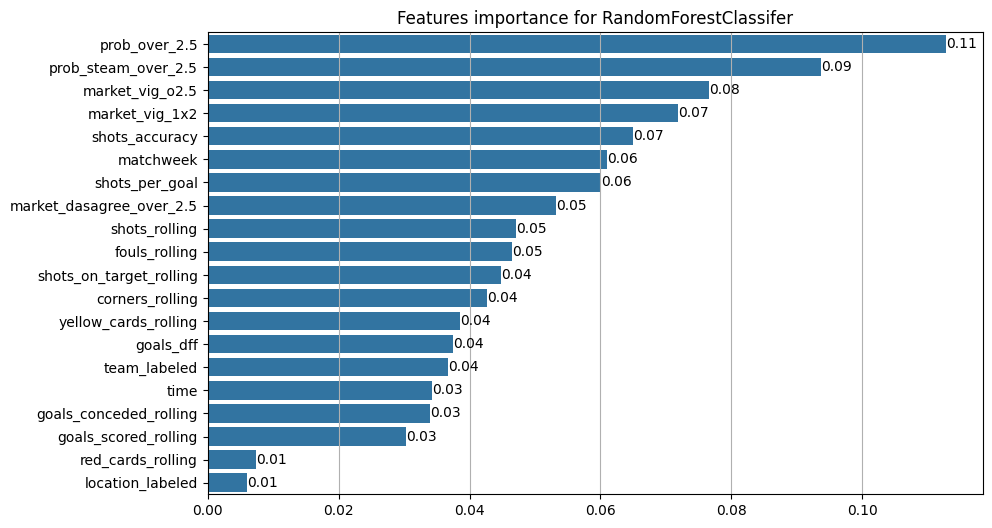

In [67]:
plt.figure(figsize=(10, 6))
ax=sns.barplot(data= best_features.sort_values(ascending=False),
            orient="h",
            estimator="sum",
            errorbar=None)
ax.bar_label(ax.containers[0], fontsize=10, fmt="%.2f");
plt.title("Features importance for RandomForestClassifer");

In [68]:
y_pred_rf = grid.predict(X_test)

In [69]:
rand_forest_results["acc"].append(accuracy_score(y_pred=y_pred_rf, y_true=y_test))
rand_forest_results["prec"].append(precision_score(y_pred=y_pred_rf, y_true=y_test))
rand_forest_results["recall"].append(recall_score(y_pred=y_pred_rf, y_true=y_test))
rand_forest_results["f1"].append(f1_score(y_pred=y_pred_rf, y_true=y_test))


### Model Training: Logistic Regression Pipeline

#### Pipeline and Model Training
- The pipeline includes `PolynomialFeatures` (degree=2) to capture non-linear relationships, `StandardScaler` to standardize features, and LogisticRegression with balanced class weights to handle class imbalance.  
- The model is trained on historical match data and predicts future match outcomes, such as over 2.5 goal matches.  
- Precision is used as the evaluation metric to focus on the precision of predicted over 2.5 goal matches.


In [70]:
lr = LogisticRegression(random_state=77,
                        class_weight="balanced")
lr_pipeline = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), StandardScaler(), lr)

In [71]:
lr_pipeline.fit(X_train, y_train);
y_pred_lr = lr_pipeline.predict(X_test)

In [72]:
log_reg_results["acc"].append(accuracy_score(y_pred=y_pred_lr, y_true=y_test))
log_reg_results["prec"].append(precision_score(y_pred=y_pred_lr, y_true=y_test))
log_reg_results["recall"].append(recall_score(y_pred=y_pred_lr, y_true=y_test))
log_reg_results["f1"].append(f1_score(y_pred=y_pred_lr, y_true=y_test))


### Model Training: Support Vector Classification Pipeline

#### Pipeline and Model Training
- The pipeline includes `StandardScaler` to normalize features, `LinearDiscriminantAnalysis` for dimensionality reduction, and SVC with a polynomial kernel, balanced class weights, and probability estimates.  
- The model is trained on historical match data and predicts future match outcomes, such as over 2.5 goal matches.  
- Precision is used as the evaluation metric to focus on the precision of predicted over 2.5 goal matches.


In [73]:
svc_pipeline = make_pipeline(
    StandardScaler(),
    LinearDiscriminantAnalysis(),
    SVC(probability=True, class_weight='balanced', C=100, kernel="poly"))

In [74]:
svc_pipeline.fit(X_train, y_train);

In [75]:
y_pred_svc = svc_pipeline.predict(X_test)

In [76]:
svc_results["acc"].append(accuracy_score(y_pred=y_pred_svc, y_true=y_test))
svc_results["prec"].append(precision_score(y_pred=y_pred_svc, y_true=y_test))
svc_results["recall"].append(recall_score(y_pred=y_pred_svc, y_true=y_test))
svc_results["f1"].append(f1_score(y_pred=y_pred_svc, y_true=y_test))


### Lag Feature Engineering and Model Optimization

#### Function Overview
- The `lagged_frame()` function creates lagged versions of selected features, introducing past values of `y` as additional predictors.  
- The `best_lags_for_model()` function tests multiple lag configurations using time-series cross-validation to find the optimal lag depth for each model.  
- Models evaluated include `Random Forest`, `Logistic Regression`, and `Support Vector Classification`.

#### Impact of Lags on Model Performance
- Lag features help capture temporal dependencies — how previous match outcomes influence future ones.  
- Including the right number of lags can significantly improve predictive accuracy and stability, while not suitable lags may introduce noise and overfitting.  
- The optimal lag count is determined separately for each model based on `precision` metric, ensuring the most reliable identification of true over 2.5 goal predictions.


With the best lag configurations identified, the next step involves training and testing all models with their respective lagged datasets to evaluate how temporal context affects predictive performance.


In [77]:
def lagged_frame(data: pd.DataFrame, num_of_lags=5, cols_to_lag: list = []):
    df_temp = data.copy()
    global lagged_cols
    lagged_cols = []
    for col in cols_to_lag:
        for lag in range(1, num_of_lags + 1):
            new_col_name = f'{col}_lag_{lag}'
            lagged_cols.append(new_col_name)
            df_temp[new_col_name] = df_temp[col].shift(lag)
    return df_temp


In [78]:
def best_lags_for_model(data: pd.DataFrame, max_num_of_lags: int, model, cols_to_lag: list = [], cv=5, scoring_metric="precision"):
  data = data.copy()
  results_dict = {}
  for lag in range(max_num_of_lags):
    data_lagged = lagged_frame(data, num_of_lags=lag, cols_to_lag=cols_to_lag)
    data_lagged = data_lagged.dropna()
    X, y = data_lagged.drop("y_over_2", axis=1), data_lagged.y_over_2
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=77)

    tscv = TimeSeriesSplit(n_splits=cv)
    scores = cross_val_score(model, X, y, cv=tscv, scoring=scoring_metric)
    results_dict[lag] = scores.mean()
  return pd.Series(results_dict).sort_values(ascending=False)

In [79]:
rf_num_of_lags = best_lags_for_model(df_rolling[features_cols+concs_from_bets], max_num_of_lags=7, model=RandomForestClassifier(class_weight="balanced"), cols_to_lag=["y_over_2"]).index[0]
rf_num_of_lags

np.int64(5)

In [80]:
lr_num_of_lags = best_lags_for_model(df_rolling[features_cols+concs_from_bets], max_num_of_lags=7, model=lr_pipeline, cols_to_lag=["y_over_2"]).index[0]
lr_num_of_lags

np.int64(3)

In [81]:
svc_num_of_lags = best_lags_for_model(df_rolling[features_cols+concs_from_bets], max_num_of_lags=5, model=svc_pipeline, cols_to_lag=["y_over_2"]).index[0]
svc_num_of_lags

np.int64(4)

In [82]:
lagged_rolling_frame_rf = lagged_frame(df_rolling, num_of_lags=rf_num_of_lags,cols_to_lag=["y_over_2"])
lagged_rolling_frame_rf.dropna(inplace=True)

In [100]:
X_train_lagged, X_test_lagged, y_train_lagged, y_test_lagged = train_test_split(lagged_rolling_frame_rf[features_cols+concs_from_bets].drop(["y_over_2", "red_cards_rolling", "location_labeled"], axis=1), lagged_rolling_frame_rf[features_cols+concs_from_bets].y_over_2,
                                                                                test_size=0.2,
                                                                                random_state=77,
                                                                                shuffle=False)


In [84]:
rf_lagged = RandomForestClassifier(random_state=77,
                            class_weight="balanced")


In [85]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}
grid = GridSearchCV(rf_lagged, param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=1, scoring='precision')
grid.fit(X_train_lagged, y_train_lagged);
y_pred_rf_lagged = grid.predict(X_test_lagged)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [86]:
rand_forest_results["acc"].append(accuracy_score(y_pred=y_pred_rf_lagged, y_true=y_test_lagged))
rand_forest_results["prec"].append(precision_score(y_pred=y_pred_rf_lagged, y_true=y_test_lagged))
rand_forest_results["recall"].append(recall_score(y_pred=y_pred_rf_lagged, y_true=y_test_lagged))
rand_forest_results["f1"].append(f1_score(y_pred=y_pred_rf_lagged, y_true=y_test_lagged))


In [87]:
y_test.value_counts()

,count
y_over_2,
1.0,255
0.0,184


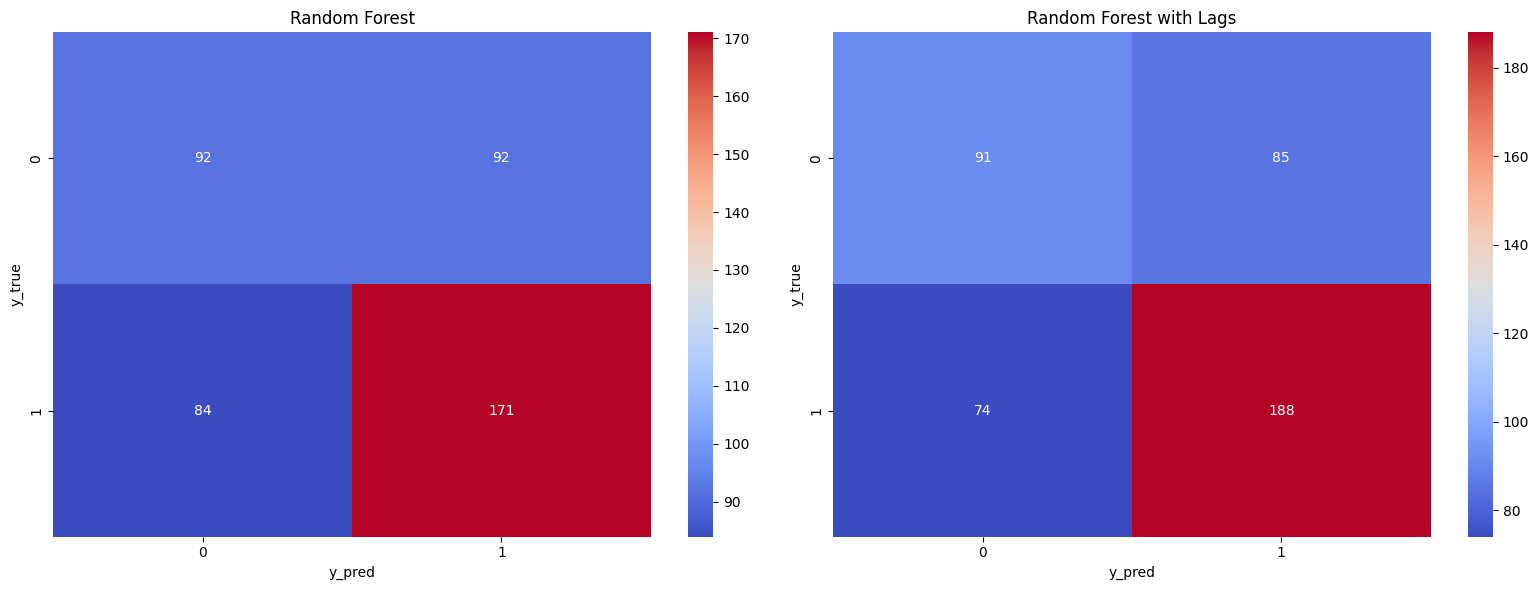

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(
    confusion_matrix(y_true=y_test, y_pred=y_pred_rf),
    annot=True,
    cmap="coolwarm",
    fmt="d",
    ax=axes[0]
)
axes[0].set_title("Random Forest")
axes[0].set_ylabel("y_true")
axes[0].set_xlabel("y_pred")
axes[0].grid(False)

sns.heatmap(
    confusion_matrix(y_true=y_test_lagged, y_pred=y_pred_rf_lagged),
    annot=True,
    cmap="coolwarm",
    fmt="d",
    ax=axes[1]
)
axes[1].set_title("Random Forest with Lags")
axes[1].set_ylabel("y_true")
axes[1].set_xlabel("y_pred")
axes[1].grid(False)

plt.tight_layout()

In [89]:
lagged_rolling_frame_lr = lagged_frame(df_rolling, num_of_lags=lr_num_of_lags,cols_to_lag=["y_over_2"])
lagged_rolling_frame_lr.dropna(inplace=True)

X_train_lagged, X_test_lagged, y_train_lagged, y_test_lagged = train_test_split(lagged_rolling_frame_lr[features_cols+concs_from_bets].drop("y_over_2", axis=1), lagged_rolling_frame_lr[features_cols+concs_from_bets].y_over_2,
                                                                                test_size=0.2,
                                                                                random_state=77,
                                                                                shuffle=False)


In [90]:
lr_lagged = LogisticRegression(random_state=77,
                        class_weight="balanced")

lr_pipeline_lagged = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), StandardScaler(), lr_lagged)


In [91]:
lr_pipeline_lagged.fit(X_train_lagged, y_train_lagged);
y_pred_lr_lagged = lr_pipeline.predict(X_test_lagged)

In [92]:
log_reg_results["acc"].append(accuracy_score(y_pred=y_pred_lr_lagged, y_true=y_test_lagged))
log_reg_results["prec"].append(precision_score(y_pred=y_pred_lr_lagged, y_true=y_test_lagged))
log_reg_results["recall"].append(recall_score(y_pred=y_pred_lr_lagged, y_true=y_test_lagged))
log_reg_results["f1"].append(f1_score(y_pred=y_pred_lr_lagged, y_true=y_test_lagged))

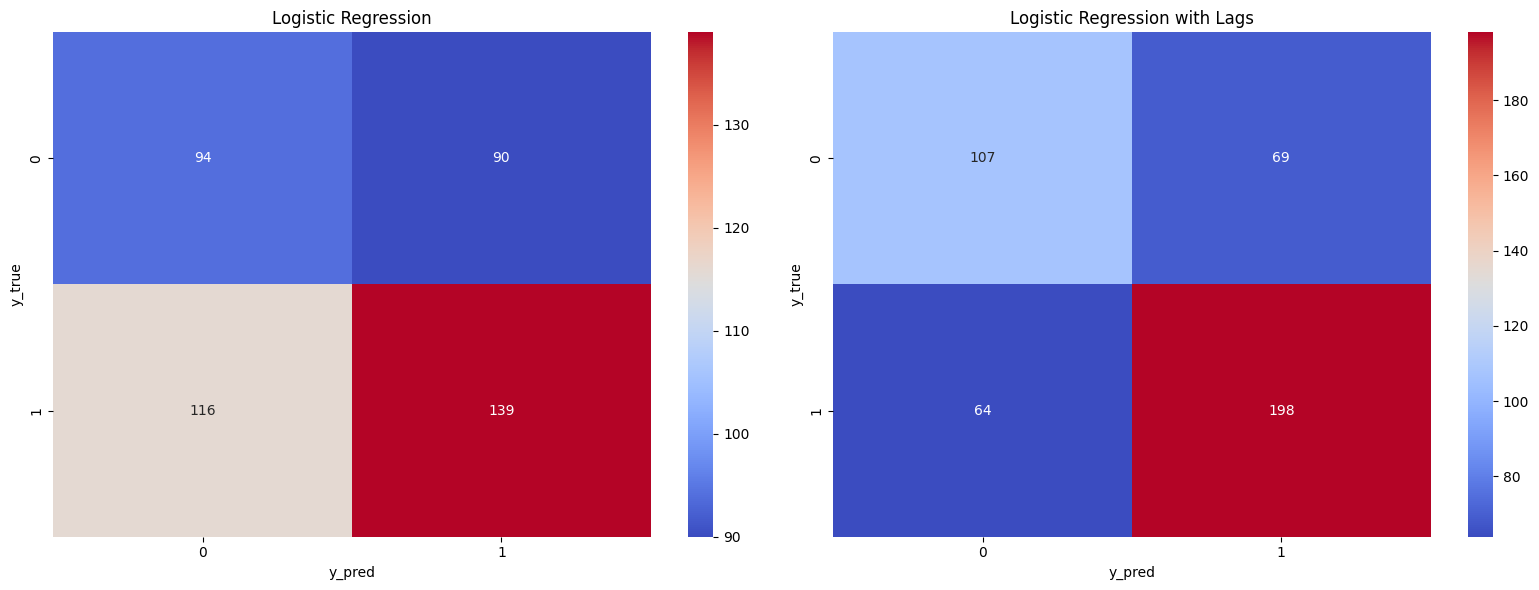

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(
    confusion_matrix(y_true=y_test, y_pred=y_pred_lr),
    annot=True,
    cmap="coolwarm",
    fmt="d",
    ax=axes[0]
)
axes[0].set_title("Logistic Regression")
axes[0].set_ylabel("y_true")
axes[0].set_xlabel("y_pred")
axes[0].grid(False)

sns.heatmap(
    confusion_matrix(y_true=y_test_lagged, y_pred=y_pred_lr_lagged),
    annot=True,
    cmap="coolwarm",
    fmt="d",
    ax=axes[1]
)
axes[1].set_title("Logistic Regression with Lags")
axes[1].set_ylabel("y_true")
axes[1].set_xlabel("y_pred")
axes[1].grid(False)

plt.tight_layout()

In [94]:
lagged_rolling_frame_svc = lagged_frame(df_rolling, num_of_lags=svc_num_of_lags,cols_to_lag=["y_over_2"])
lagged_rolling_frame_svc.dropna(inplace=True)

X_train_lagged, X_test_lagged, y_train_lagged, y_test_lagged = train_test_split(lagged_rolling_frame_svc[features_cols+concs_from_bets].drop("y_over_2", axis=1), lagged_rolling_frame_svc[features_cols+concs_from_bets].y_over_2,
                                                                                test_size=0.2,
                                                                                random_state=77,
                                                                                shuffle=False)


In [95]:
svc_pipeline = make_pipeline(
    StandardScaler(),
    LinearDiscriminantAnalysis(),
    SVC(probability=True, class_weight='balanced', C=100, kernel="poly"))

svc_pipeline.fit(X_train_lagged, y_train_lagged);
y_pred_svc_lagged = svc_pipeline.predict(X_test_lagged)


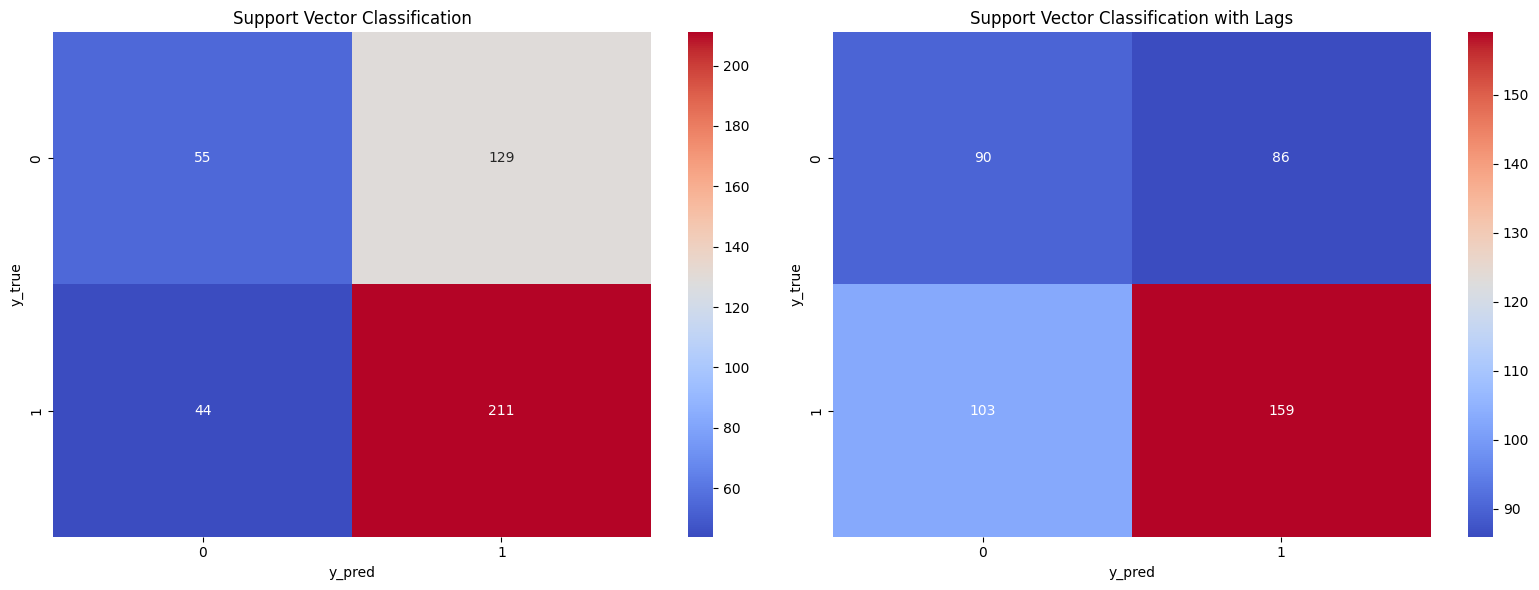

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(
    confusion_matrix(y_true=y_test, y_pred=y_pred_svc),
    annot=True,
    cmap="coolwarm",
    fmt="d",
    ax=axes[0]
)
axes[0].set_title("Support Vector Classification")
axes[0].set_ylabel("y_true")
axes[0].set_xlabel("y_pred")
axes[0].grid(False)

sns.heatmap(
    confusion_matrix(y_true=y_test_lagged, y_pred=y_pred_svc_lagged),
    annot=True,
    cmap="coolwarm",
    fmt="d",
    ax=axes[1]
)
axes[1].set_title("Support Vector Classification with Lags")
axes[1].set_ylabel("y_true")
axes[1].set_xlabel("y_pred")
axes[1].grid(False)

plt.tight_layout()

In [97]:
svc_results["acc"].append(accuracy_score(y_pred=y_pred_svc_lagged, y_true=y_test_lagged))
svc_results["prec"].append(precision_score(y_pred=y_pred_svc_lagged, y_true=y_test_lagged))
svc_results["recall"].append(recall_score(y_pred=y_pred_svc_lagged, y_true=y_test_lagged))
svc_results["f1"].append(f1_score(y_pred=y_pred_svc_lagged, y_true=y_test_lagged))


In [98]:
forest_frame = pd.DataFrame(rand_forest_results).T
forest_frame.columns =["RandomForest", "RandomForest_laggs"]

log_frame = pd.DataFrame(log_reg_results).T
log_frame.columns =["LogisticRegression", "LogisticRegression_laggs"]

svc_frame = pd.DataFrame(svc_results).T
svc_frame.columns =["SVC",  "SVC_laggs"]


results = pd.concat([forest_frame, log_frame, svc_frame], axis=1)
results

,RandomForest,RandomForest_laggs,LogisticRegression,LogisticRegression_laggs,SVC,SVC_laggs
acc,0.599089,0.636986,0.530752,0.696347,0.605923,0.568493
prec,0.650190,0.688645,0.606987,0.741573,0.620588,0.648980
recall,0.670588,0.717557,0.545098,0.755725,0.827451,0.606870
f1,0.660232,0.702804,0.574380,0.748582,0.709244,0.627219


### Final Model Evaluation and Interpretation

#### Evaluation Metrics
- **Accuracy (acc)**: Overall proportion of correct predictions.  
- **Precision (prec)**: Among all matches predicted as over 2.5, how many were truly over 2.5. High precision reduces false bets.  
- **Recall**: Among all true over 2.5 matches, how many were correctly identified. High recall means fewer missed opportunities.  
- **F1-score**: Harmonic mean of precision and recall, providing a balanced measure of both accuracy and coverage.

---

#### Random Forest
- Without lags: `Accuracy = 0.599`, `Precision = 0.650`, `Recall = 0.671`, `F1 = 0.660`.  
- With lags: `Accuracy = 0.637`, `Precision = 0.689`, `Recall = 0.718`, `F1 = 0.703`.  
Lag features improved both recall and F1, indicating better generalization and more confident over 2.5 predictions.

---

#### Logistic Regression
- Without lags: `Accuracy = 0.531`, `Precision = 0.607`, `Recall = 0.545`, `F1 = 0.574`.  
- With lags: `Accuracy = 0.696`, `Precision = 0.742`, `Recall = 0.756`, `F1 = 0.749`.  
Logistic Regression benefited the most from adding lags. Both precision and recall increased strongly, making it the best-performing model overall.

---

#### Support Vector Classification (SVC)
- Without lags: `Accuracy = 0.606`, `Precision = 0.621`, `Recall = 0.827`, `F1 = 0.709`.  
- With lags: `Accuracy = 0.568`, `Precision = 0.649`, `Recall = 0.607`, `F1 = 0.627`.  
Adding lags slightly improved precision but significantly reduced recall, leading to weaker overall performance.

---

### Summary
- Introducing lag features generally improved accuracy and precision across models, meaning more confident and correct predictions.  
- `Logistic Regression with lags` achieved the best results overall, with the highest accuracy (0.696) and F1-score (0.749).  
- `Random Forest with lags` also improved moderately, showing consistent and reliable performance.  
- `SVC` struggled with lag features, losing recall and accuracy.  

*Conclusion:* Lagged features enhance model stability and predictive confidence for over 2.5 goal predictions, especially in Logistic Regression and Random Forest models.
